In [ ]:
Quit[]

# A tutorial to use QuantumManyBody package

This notebook has to be considered as a tutorial, which will explain how to use the QuantumManyBody package to perform numerical computations. The package can be useful to simulate quantum mechanical systems in $1$ dimension; such as spin chain models (having, say, $L$, spin sites) and the so-called SYK model, which is a strongly interacting model of $N$ Majorana fermions, which will be included and discussed in a dedicated section.

First of all, let us load the package:

In [1]:
Needs["QuantumManyBody`"] 

and we will focus first on showing functionalities which can be used to generate spin chain Hamiltonians (although, the vast majority of the functions can be used for Majorana Hamiltonians too). For simplicity, we will consider chains having $10$ sites, which are then associated to Hilbert spaces of dimension $2^10$

In [2]:
latticeSize = 10;
length = 2^latticeSize;

## Creating spin chain Hamiltonians using `SpinChainHamiltonian` and `SpinOperators`

The first function we want to address is the function `SpinChainHamiltonian[listCouplings , listCoefficients]`. Most of the Hamiltonians used in condensed matter are built out of lattices (defined on graphs) in which the spin variables (that here we call $\sigma_i^a$, with $i$ being the site on the graph and $a = x, y, z$ being the orientation of the spin along the $3$ axes) interact through scalar products when they are connected by an edge of the underlying graph.

We will see through some examples, which kind of Hamiltonians can be generated and how.

### The Heisenberg model example

To start with, we will consider probably the simplest yet non-trivial example of Hamiltonian: the Heisenberg chain with periodic boundary conditions. In this model, the spins variables are placed on a necklace like graph;  only the nearest neighbors sites interact among each other, with a constant coupling. In formulas, the Hamiltonian reads

$$
H_\mathrm{Heis} = \sum_{(i , j)} \sum_{a = 1}^3 \, \sigma_i^a \cdot \sigma_j^a \ ,
$$

where the notation $(i, j)$ denotes the nearest neighbors pairs.

To build this hamiltonian, we first create a list, which contains all the nearest neighbors pairs

In [4]:
listCouplings = Partition[Range @ latticeSize , 2 , 1 , 1]

{{1, 2}, {2, 3}, {3, 4}, {4, 5}, {5, 6}, {6, 7}, {7, 8}, {8, 9}, {9, 10}, {10, 1}}

Notice that we are assuming periodic boundary conditions, given the presence of the coupling $\left\{10 , 1\right\}$. We can similarly consider the case with open boundary conditions

In [5]:
listCouplingsOpen = Partition[Range @ latticeSize , 2 , 1]

{{1, 2}, {2, 3}, {3, 4}, {4, 5}, {5, 6}, {6, 7}, {7, 8}, {8, 9}, {9, 10}}

In which we see that the last coupling $\left\{10 , 1\right\}$, which was "closing" the necklace, is now removed. From the formula for the Hamiltonian $H_\mathrm{Heis}$, we see that, for each non trivial coupling $(i, j)$ the three spin operators are coupled  isotropically with strength one. From this we learn that the list of the coefficients, `listCoefficients`, is simply given by 

In [7]:
listCoefficients = ({1 , 1 , 1} &) /@ Range @ Length @ listCouplings;

Given these two ingredients, we are ready to build our Hamiltonian, using `SpinChainHamiltonian`

In [8]:
{hamiltonianHeisenbergDecomposed , hamiltonianHeisenberg} = 
 SpinChainHamiltonian[listCouplings , listCoefficients];

As we see, the output is given by two lists: the first list, here called `hamiltonianHeisenbergDecomposed`, contains all the single terms $\sigma_i^a \cdot \sigma_j^a$, organized as a nested list, in which, for each non-vanishing choice of the site indices $i$ and $j$, the three individual terms with $a = x, y, z$ are separately considered. This list is relevant because each element has the property of being proportional to a unitary operator (in this particular example they are effectively unitary). Hence, `hamiltonianHeisenbergDecomposed` can be useful when we deal with algorithms which make use of a Trotterization of the Hamiltonian (we will see an example  in a later section).
The second list, here called `hamiltonianHeisenberg` denotes instead the full Heisenberg Hamiltonian, $H_\mathrm{Heis}$.

All the resulting matrices are given as `SparseArray`. This is convenient, since the Heisenberg Hamiltonian, as well as most of the Hamiltonians used in condensed matter physics, are very sparse: we can get convinced by this last point using a `MatrixPlot`

-Graphics-
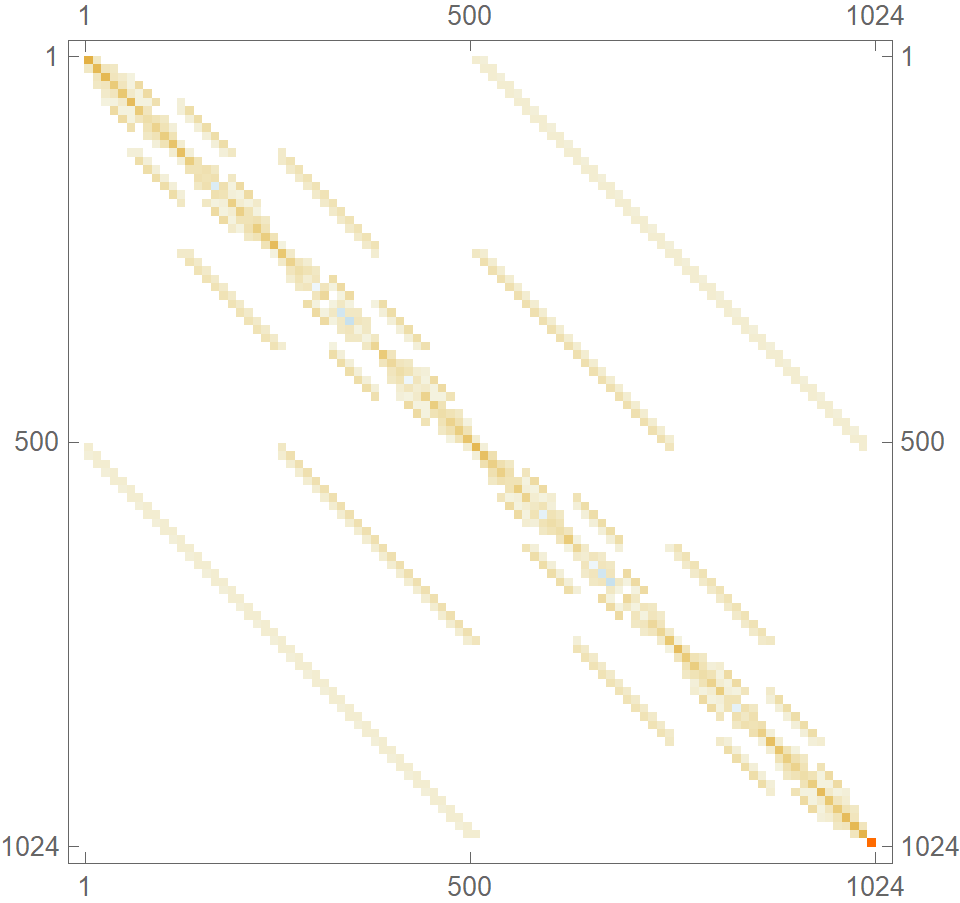

In [9]:
hamiltonianHeisenberg // MatrixPlot

### A more interesting example

Let us now turn to a more interesting example: we will consider an Hamiltonian having both single site terms as well as nearest neighbors and next-to-nearest neighbors couplings. It reads (we are assuming here open boundary conditions)
$$
H = h \, \sum_{i = 1}^L \sigma_i^x - \sum_{i = 1}^{L - 1}J_i \sigma_i^z \cdot \sigma_{i + 1}^z + J_2 \sum_{i = 1}^{L - 2} \sigma_i^z \cdot \sigma_{i + 2}^z \equiv H_0 + H_1 + H_2 \ ,
$$